In [1]:
from collections import defaultdict
import numpy as np
import random

In [2]:
class Maze():
    def __init__(self, size, blocking_pos, goal):
        """

        :param size: tuple (width, height)
        :param blocking_pos: [(x,y), ...] positions of blocking mazes.
                             Here, expect lower left corner as origin and start from 1
        :param goal: (x,y) position of goal

        Example:
        size = (3,3)
        blocking_pos = [(1,1)]
        goal = (3,3)

        Result Maze:
        0 0 g
        0 0 0
        1 0 0
        where 1 is blocking block and g is the goal
        """
        self.width, self.height = size
        self.blocking_pos = blocking_pos
        self.goal = goal

    def step(self, current_state, action):
        """
        :param current_state: (x,y) current pos
        :param action: action from ['up', 'down', 'right', 'left']
        :return: reward, next_state
        """
        x, y = current_state
        dx, dy = 0, 0
        if action == 'up':
            dy = 1
        elif action == 'down':
            dy = -1
        elif action == 'left':
            dx = -1
        elif action == 'right':
            dx = 1
        else:
            raise ValueError(f'action {action} is undefined')

        # make sure they are in bound
        x_change = min(self.width, max(1, x+dx))
        y_change = min(self.height, max(1, y+dy))

        # make sure they are not blocked
        if (x_change, y_change) in self.blocking_pos:
            # rollback
            x_change, y_change = x,y

        # check goal
        if (x_change, y_change) == self.goal:
            reward = 1
        else:
            reward = 0

        return reward, (x_change, y_change)

In [3]:
class DynaQ:
    def __init__(self, alpha=0.1, gamma=0.95, eps=0.2, planning_n = 50):
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
        self.planning_n = planning_n
        self.action_space = ['up', 'down', 'right', 'left']
        self.model = defaultdict(int)
        self.Q = defaultdict(int)
        # key in both Q and model: tuple((x,y),a)

    def greedy(self, state):
        Q_list = [self.Q[state,a] for a in self.action_space]
        _max = max(Q_list)
        if _max == 0:
            # no actions has been learned
            return np.random.choice(self.action_space)
        else:
            tie_actions = []
            for i, q in enumerate(Q_list):
                if  q == _max:
                    tie_actions.append(self.action_space[i])
            return np.random.choice(tie_actions)

    def eps_greedy(self, state):
        if np.random.random() > self.eps:
            return self.greedy(state)
        else:
            # return a random action
            return np.random.choice(self.action_space)

    def update(self, state, action, next_state, reward):
        greedy_action = self.greedy(next_state)
        self.Q[state,action] += self.alpha*(reward + self.gamma*self.Q[next_state,greedy_action] - self.Q[state,action])

    def model_update(self, state, action, next_state, reward):
        self.model[state,action] = reward, next_state

    def planning(self):
        for _ in range(self.planning_n):
            state, action = random.sample(self.model.keys(), 1)[0]
            reward, next_state = self.model[state,action]
            self.update(state, action, next_state, reward)
    def reset(self):
        self.Q = defaultdict(int)
        self.model = defaultdict(int)

In [4]:
# Most of the code here are copy paste from DynaQ
# Not using inheritance on purpose (to make copy of the class easier)
class DynaQPlus:
    def __init__(self, alpha=0.1, gamma=0.95, eps=0.2, planning_n = 50, k = 0.001):
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
        self.planning_n = planning_n
        self.action_space = ['up', 'down', 'right', 'left']
        self.model = defaultdict(int)
        self.Q = defaultdict(int)
        self.k = k
        # key in both Q and model: tuple((x,y),a)
        self.tao_dict = defaultdict(int)

    def greedy(self, state):
        Q_list = [self.Q[state,a] for a in self.action_space]
        _max = max(Q_list)
        if _max == 0:
            # no actions has been learned
            return np.random.choice(self.action_space)
        else:
            tie_actions = []
            for i, q in enumerate(Q_list):
                if  q == _max:
                    tie_actions.append(self.action_space[i])
            return np.random.choice(tie_actions)

    def eps_greedy(self, state):
        if np.random.random() > self.eps:
            action = self.greedy(state)
        else:
            # return a random action
            action = np.random.choice(self.action_space)
        for k in self.tao_dict.keys():
            if k != (state, action):
                self.tao_dict[k] += 1
        self.tao_dict[state,action] = 0
        return action

    def update(self, state, action, next_state, reward):
        greedy_action = self.greedy(next_state)
        self.Q[state,action] += self.alpha*(reward + self.gamma*self.Q[next_state,greedy_action] - self.Q[state,action])

    def model_update(self, state, action, next_state, reward):
        self.model[state,action] = reward, next_state
        
    # ------difference of dynaQ+ is here------
    def bonus(self, state, action):
        return self.k*np.sqrt(self.tao_dict[state,action])
    def planning(self):
        for _ in range(self.planning_n):
            state, action = random.sample(self.model.keys(), 1)[0]
            reward, next_state = self.model[state,action]
            bonus = self.bonus(state,action)
            self.update(state, action, next_state, reward+bonus)
            
            
    # ------difference of dynaQ+ is here------
            
    def reset(self):
        self.Q = defaultdict(int)
        self.model = defaultdict(int)
        self.tao_dict = defaultdict(int)
        

In [5]:
class DynaQPlusExperiment:
    def __init__(self, alpha=0.1, gamma=0.95, eps=0.2, planning_n = 50, k = 0.001):
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
        self.planning_n = planning_n
        self.action_space = ['up', 'down', 'right', 'left']
        self.model = defaultdict(int)
        self.Q = defaultdict(int)
        self.k = k
        # key in both Q and model: tuple((x,y),a)
        self.tao_dict = defaultdict(int)

    def greedy(self, state):
        Q_list = [self.Q[state,a] + self.bonus(state,a) for a in self.action_space]
        _max = max(Q_list)
        if _max == 0:
            # no actions has been learned
            return np.random.choice(self.action_space)
        else:
            tie_actions = []
            for i, q in enumerate(Q_list):
                if  q == _max:
                    tie_actions.append(self.action_space[i])
            return np.random.choice(tie_actions)

    def eps_greedy(self, state):
        if np.random.random() > self.eps:
            action = self.greedy(state)
        else:
            # return a random action
            action = np.random.choice(self.action_space)
        for k in self.tao_dict.keys():
            if k != (state, action):
                self.tao_dict[k] += 1
        self.tao_dict[state,action] = 0
        return action

    def update(self, state, action, next_state, reward):
        greedy_action = self.greedy(next_state)
        self.Q[state,action] += self.alpha*(reward + self.gamma*self.Q[next_state,greedy_action] - self.Q[state,action])

    def model_update(self, state, action, next_state, reward):
        self.model[state,action] = reward, next_state

    # ------difference of dynaQ+ is here------
    def bonus(self, state, action):
        return self.k*np.sqrt(self.tao_dict[state,action])
    def planning(self):
        for _ in range(self.planning_n):
            state, action = random.sample(self.model.keys(), 1)[0]
            reward, next_state = self.model[state,action]
            self.update(state, action, next_state, reward)


    # ------difference of dynaQ+ is here------

    def reset(self):
        self.Q = defaultdict(int)
        self.model = defaultdict(int)
        self.tao_dict = defaultdict(int)


In [6]:
def game(agent):
    EXPERIMENT = 5
    HIST = []
    # set env the one in Figure 8.2 of the book
    env = Maze(size = (9,6), blocking_pos=[(3,3), (3,4), (3,5), (6,2), (8,4), (8,5), (8,6)], goal = (9,6))
    EPISODE = 150
    for experiment in range(EXPERIMENT):
        agent.reset()
        print(f'expeirment {experiment}')
        hist = []
        for episode in range(EPISODE):
            if episode == 50:
                # adding block
                env.blocking_pos.append((3,6))
                env.blocking_pos.append((3,2))
                env.blocking_pos.append((8,4))
                env.blocking_pos.append((8,5))
            if episode == 100:
                # removing another block
                env.blocking_pos = []
            state = (1,4)
            for step in range(100000):
                action = agent.eps_greedy(state)
                reward, next_state = env.step(state,action)
                # direct learn
                agent.update(state, action, next_state, reward)
                agent.model_update(state, action, next_state, reward)
                if (step+1) % 1000 == 0:
                    print(step)
                if episode >= 1:
                    agent.planning()
                state = next_state
                if reward == 1:
                    hist.append(step)
                    break
            # start test
        HIST.append(hist)
    HIST = np.mean(HIST, axis = 0)
    return HIST

In [7]:
# outer loop part
HIST_DynaQ_5 = game(DynaQ(planning_n = 5))
HIST_DynaQ_50 = game(DynaQ(planning_n = 50))

expeirment 0
expeirment 1
expeirment 2
expeirment 3
expeirment 4
expeirment 0
999
expeirment 1
999
expeirment 2
expeirment 3
expeirment 4


In [8]:
HIST_DynaQPlus_5 = game(DynaQPlus(planning_n = 5))
HIST_DynaQPlus_50 = game(DynaQPlus(planning_n = 50))

expeirment 0
expeirment 1
expeirment 2
expeirment 3
expeirment 4
expeirment 0
999
expeirment 1
expeirment 2
expeirment 3
expeirment 4


In [9]:
HIST_DynaQPlus_5_EXP = game(DynaQPlusExperiment(planning_n = 5))
HIST_DynaQPlus_50_EXP = game(DynaQPlusExperiment(planning_n = 50))

expeirment 0
expeirment 1
expeirment 2
expeirment 3
expeirment 4
expeirment 0
expeirment 1
expeirment 2
expeirment 3
expeirment 4


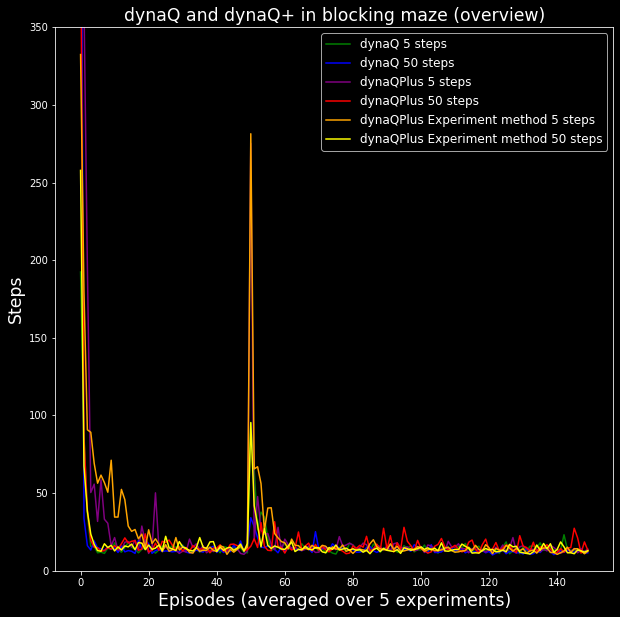

In [17]:
# draw part
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.figure(figsize=(10, 10))
plt.ylim(top=350)
plt.title('dynaQ and dynaQ+ in blocking maze (overview)', fontsize = 'xx-large')
plt.xlabel('Episodes (averaged over 5 experiments)', fontsize = 'xx-large')
plt.ylabel('Steps',fontsize = 'xx-large')
plt.plot(HIST_DynaQ_5, '-', c = 'green', label = 'dynaQ 5 steps')
plt.plot(HIST_DynaQ_50, '-', c = 'blue', label = 'dynaQ 50 steps')

plt.plot(HIST_DynaQPlus_5, '-', c = 'purple', label = 'dynaQPlus 5 steps')
plt.plot(HIST_DynaQPlus_50, '-', c = 'red', label = 'dynaQPlus 50 steps')

plt.plot(HIST_DynaQPlus_5_EXP, '-', c = 'orange', label = 'dynaQPlus Experiment method 5 steps')
plt.plot(HIST_DynaQPlus_50_EXP, '-', c = 'yellow', label = 'dynaQPlus Experiment method 50 steps')
plt.legend(loc = 'best', prop = {'size':12})
plt.show()

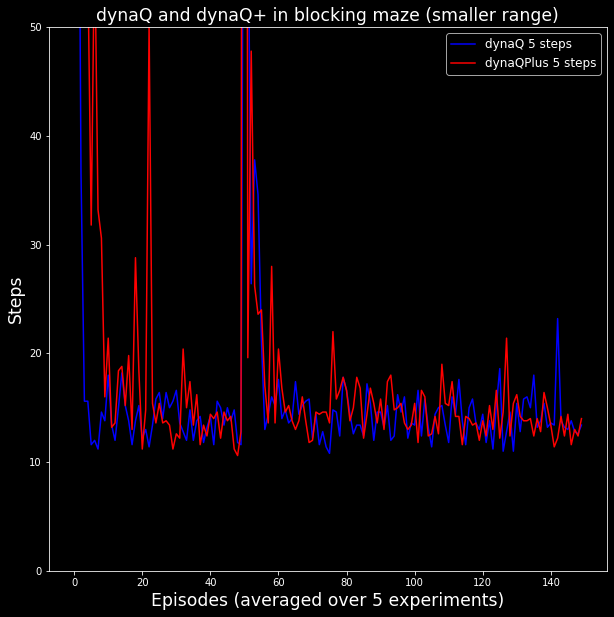

In [19]:
plt.style.use('dark_background')
plt.figure(figsize=(10, 10))
plt.ylim(top=50)
plt.title('dynaQ and dynaQ+ in blocking maze (smaller range)', fontsize = 'xx-large')
plt.xlabel('Episodes (averaged over 5 experiments)', fontsize = 'xx-large')
plt.ylabel('Steps',fontsize = 'xx-large')
plt.plot(HIST_DynaQ_5, '-', c = 'blue', label = 'dynaQ 5 steps')

plt.plot(HIST_DynaQPlus_5, '-', c = 'red', label = 'dynaQPlus 5 steps')
plt.legend(loc = 'best', prop = {'size':12})
plt.show()

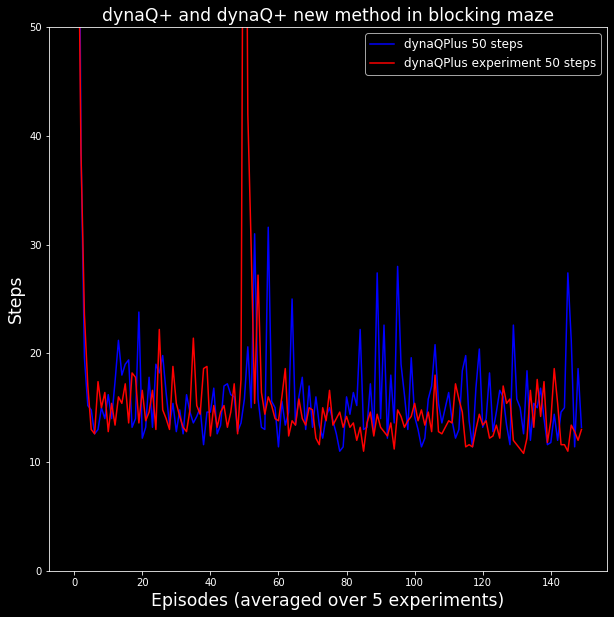

In [18]:
plt.style.use('dark_background')
plt.figure(figsize=(10, 10))
plt.ylim(top=50)
plt.title('dynaQ+ and dynaQ+ new method in blocking maze', fontsize = 'xx-large')
plt.xlabel('Episodes (averaged over 5 experiments)', fontsize = 'xx-large')
plt.ylabel('Steps',fontsize = 'xx-large')
plt.plot(HIST_DynaQPlus_50, '-', c = 'blue', label = 'dynaQPlus 50 steps')
plt.plot(HIST_DynaQPlus_50_EXP, '-', c = 'red', label = 'dynaQPlus experiment 50 steps')
plt.legend(loc = 'best', prop = {'size':12})
plt.show()

In this experiment, I rebuild the example in figure 8.2. Then I
change block to increase the difficulty at episode 50 and eliminate all blocks
from map at episode 100.

Result: DynaQ+ with experiment method will have lower variance after convergence but
it takes much longer time to re-converge when environment get worse. I think it is due to picking
 action instead of rewriting q values will make spread of value change slower, but also make the meaningless
 exploration fewer.

All methods show insensitive with the better condition. I think it is because they are not THAT better.
Put into another experiment where optimal route is much shorter would be better.

Readers are welcomed to do their own experiment.


